# Importing required libraries.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import gensim
from spacy.lang.en import English
from tqdm import tqdm
import numpy as np
from gensim import corpora
from gensim.models import LdaModel
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open f

/kaggle/input/wallstreetbets-2022/wallstreetbets_2022.csv


# Downloading stopwords


In [2]:
# Downloading stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading the input data file.

In [3]:
df = pd.read_csv('/kaggle/input/wallstreetbets-2022/wallstreetbets_2022.csv')
df.head()

/tmp/ipykernel_28/3402394295.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/wallstreetbets-2022/wallstreetbets_2022.csv')


,title,score,id,url,comms_num,created,body,timestamp
0,Wash sale,0,txhzpp,https://www.reddit.com/r/wallstreetbets/commen...,8.0,1.649236e+09,Hi guys I bought uvxy beginning of the year in...,2022-04-06 09:14:16
1,Comment,1,i3lsqo4,NaN,0.0,1.649238e+09,Yes December 30 I sold it,2022-04-06 09:32:46
2,Comment,1,i3lrk43,NaN,0.0,1.649237e+09,![img](emote|t5_2th52|4260) Just need help,2022-04-06 09:15:56
3,Comment,1,i3lmzkh,NaN,0.0,1.649233e+09,??? Alright bro.,2022-04-06 08:10:16
4,Comment,1,i3lmz13,NaN,0.0,1.649233e+09,Elon is with more than some of the S&P 500 com...,2022-04-06 08:10:03


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457834 entries, 0 to 457833
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   title      457834 non-null  object 
 1   score      457834 non-null  object 
 2   id         457833 non-null  object 
 3   url        55956 non-null   object 
 4   comms_num  457833 non-null  float64
 5   created    457833 non-null  float64
 6   body       426083 non-null  object 
 7   timestamp  457828 non-null  object 
dtypes: float64(2), object(6)
memory usage: 27.9+ MB


# Cleaning data: filling null values and removing non-alphanumeric characters


In [5]:
# Cleaning data: filling null values and removing non-alphanumeric characters
df['body'].fillna("", inplace=True)
df['url'].fillna("No_URL", inplace=True)
df.dropna(subset=['comms_num', 'created'], inplace=True)
df['body'] = df['body'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

# Loading Spacy model


In [6]:
# Loading Spacy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Defining functions for lemmatization and preprocessing of texts.

In [7]:
def lemmatize_pipe(doc):
    return [str(tok.lemma_).lower() for tok in doc if tok.is_alpha and tok.text.lower() not in stopwords]


# Preprocessing the text data.

In [8]:
def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in tqdm(nlp.pipe(texts, batch_size=20), total=len(texts)):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

In [9]:
df['tokens'] = preprocess_pipe(df['body'])

100%|██████████| 457833/457833 [11:59<00:00, 636.54it/s] 


# Join tokens into string for wordcloud and VADER sentiment analysis


In [10]:
# Join tokens into string for wordcloud and VADER sentiment analysis
df['processed_body'] = df['tokens'].apply(' '.join)

# Print common words
common_words = Counter(" ".join(df['processed_body']).split()).most_common(10)
print("Common words: ", common_words)

Common words:  [('go', 57127), ('get', 48600), ('like', 40917), ('make', 34686), ('buy', 30539), ('see', 30383), ('market', 29667), ('think', 25299), ('would', 24805), ('stock', 22615)]


# Sentiment Analysis using VADER


In [11]:
# Sentiment Analysis using VADER
sid = SentimentIntensityAnalyzer()
df['sentiments'] = df['processed_body'].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

# Creating wordcloud


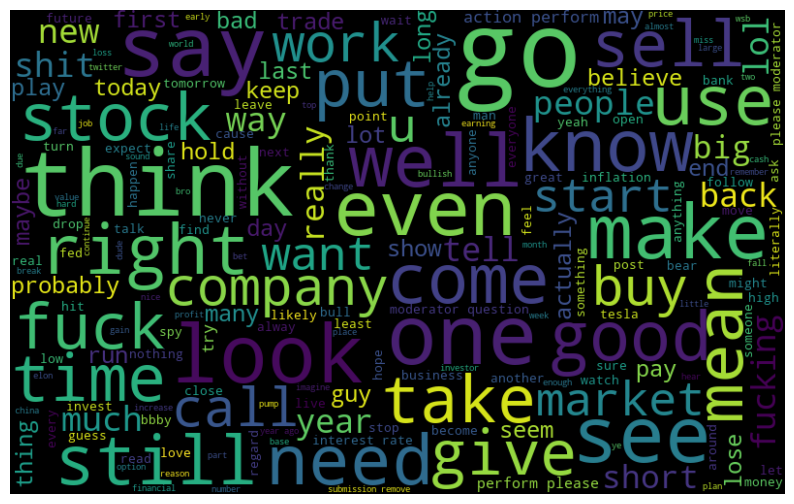

In [12]:
# Creating wordcloud
all_words = ' '.join(df['processed_body'])
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Filter positive and negative sentiments


In [13]:
# Filter positive and negative sentiments
positive_words = ' '.join(df[df['compound'] > 0]['processed_body'])
negative_words = ' '.join(df[df['compound'] < 0]['processed_body'])

# Create word clouds for positive and negative sentiments
positive_wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(positive_words)
negative_wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(negative_words)

# Plotting positive word cloud


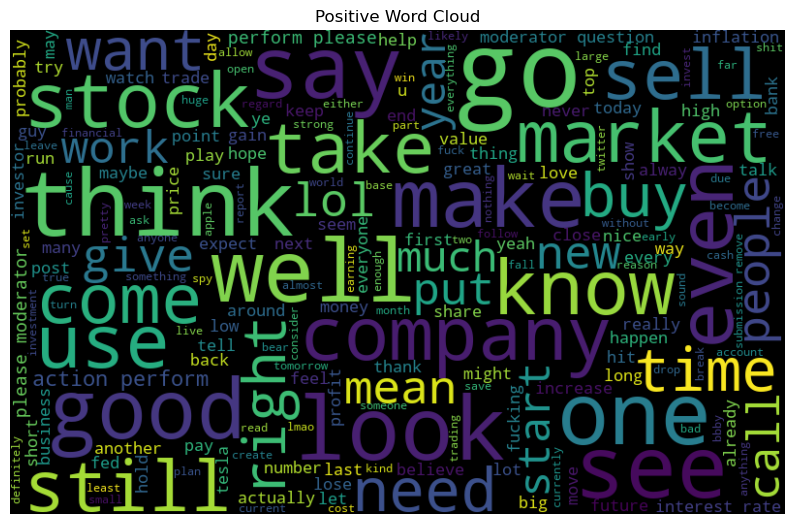

In [14]:
# Plotting positive word cloud
plt.figure(figsize=(10, 7))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Word Cloud')
plt.show()

# Plotting negative word cloud


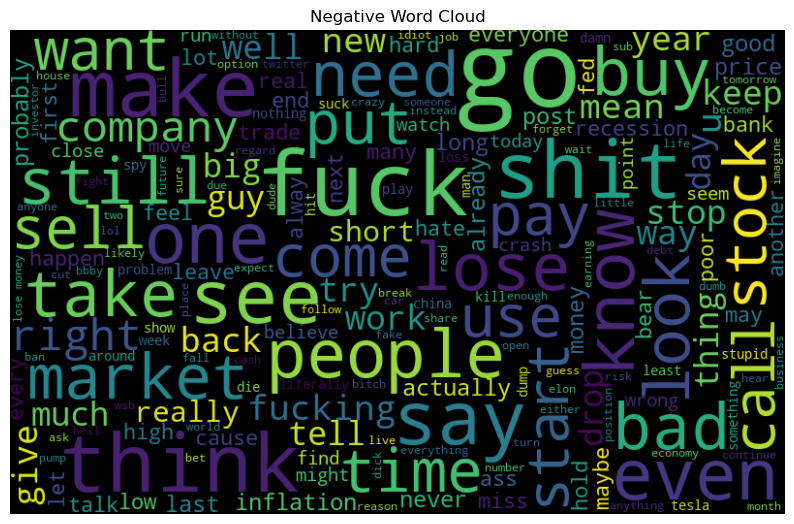

In [15]:
# Plotting negative word cloud
plt.figure(figsize=(10, 7))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Word Cloud')
plt.show()

# Topic Modelling


In [16]:
# Topic Modelling
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.042*"please" + 0.037*"post" + 0.028*"comment" + 0.028*"question" + 0.023*"action" + 0.022*"bet" + 0.022*"make" + 0.021*"bot" + 0.021*"check" + 0.020*"perform"')
(1, '0.049*"like" + 0.040*"go" + 0.024*"get" + 0.022*"know" + 0.020*"think" + 0.016*"make" + 0.014*"people" + 0.013*"say" + 0.012*"fuck" + 0.011*"shit"')
(2, '0.111*"buy" + 0.087*"call" + 0.085*"put" + 0.042*"sell" + 0.035*"lol" + 0.023*"real" + 0.023*"great" + 0.019*"someone" + 0.016*"submission" + 0.014*"either"')
(3, '0.053*"year" + 0.047*"see" + 0.023*"new" + 0.022*"good" + 0.019*"not" + 0.017*"regard" + 0.015*"month" + 0.015*"ago" + 0.013*"old" + 0.012*"imagine"')
(4, '0.024*"price" + 0.020*"market" + 0.018*"trade" + 0.014*"move" + 0.013*"look" + 0.012*"high" + 0.012*"stock" + 0.012*"option" + 0.010*"play" + 0.009*"low"')
(5, '0.054*"ai" + 0.039*"money" + 0.032*"make" + 0.022*"pay" + 0.020*"lose" + 0.017*"use" + 0.015*"people" + 0.015*"get" + 0.014*"want" + 0.013*"take"')
(6, '0.032*"day" + 0.022*"market" + 0.020*"w

# Plotting the score distribution using a violin plot.

In [17]:
print(df['score'].describe())

count     457833
unique      5868
top            1
freq      191097
Name: score, dtype: int64


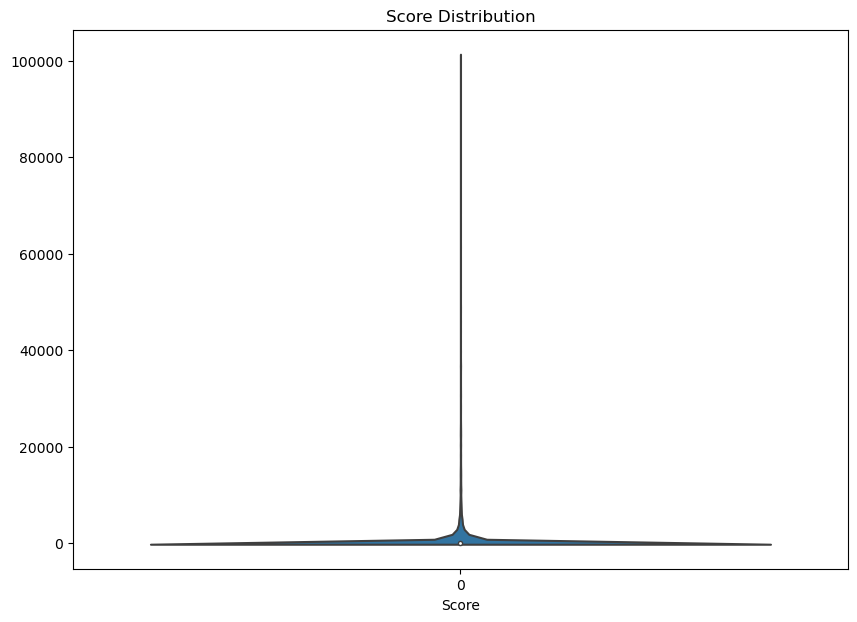

In [18]:
# EDA: Scores distribution, top topics, sentiment scores etc. can be analyzed
# Score Distribution
plt.figure(figsize=(10, 7))
sns.violinplot(df['score'])
plt.title('Score Distribution')
plt.xlabel('Score')
plt.show()

In [19]:
# Convert 'score' to numeric type
df['score'] = pd.to_numeric(df['score'], errors='coerce')

# Now you can get the top 10 posts by 'score'
top_posts = df.nlargest(10, 'score')
print(top_posts[['title', 'score']])

                                                    title   score
249582                           What a dumpster fire LOL  101229
62110                               i am Dr Michael Burry   90615
71727                           Major recession indicator   84382
218857                              Can’t touch this JPow   75142
239170                            Investors hard at work.   73696
183748                   buy now or be priced out forever   72916
79348                           Knock knock. You're next.   71156
251665  Lawsuit secured or how to cause $8+ billion in...   70316
259730                     The All Star Team of Scamming.   70222
264711                               Justin Hammer of EVs   67573


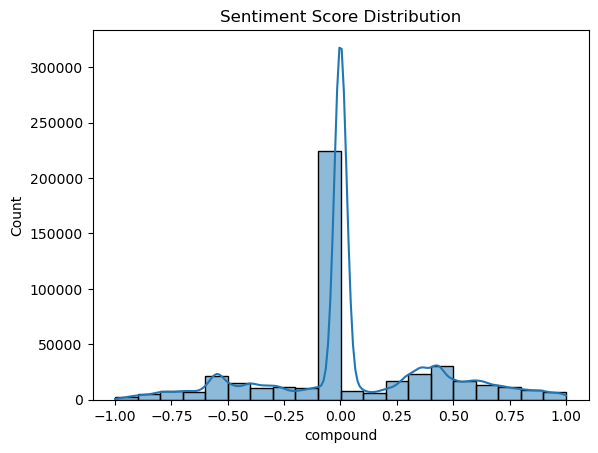

In [20]:
# Sentiment Score Analysis
sns.histplot(df['compound'], kde=True, bins=20)
plt.title('Sentiment Score Distribution')
plt.show()

# Post vs. Comments


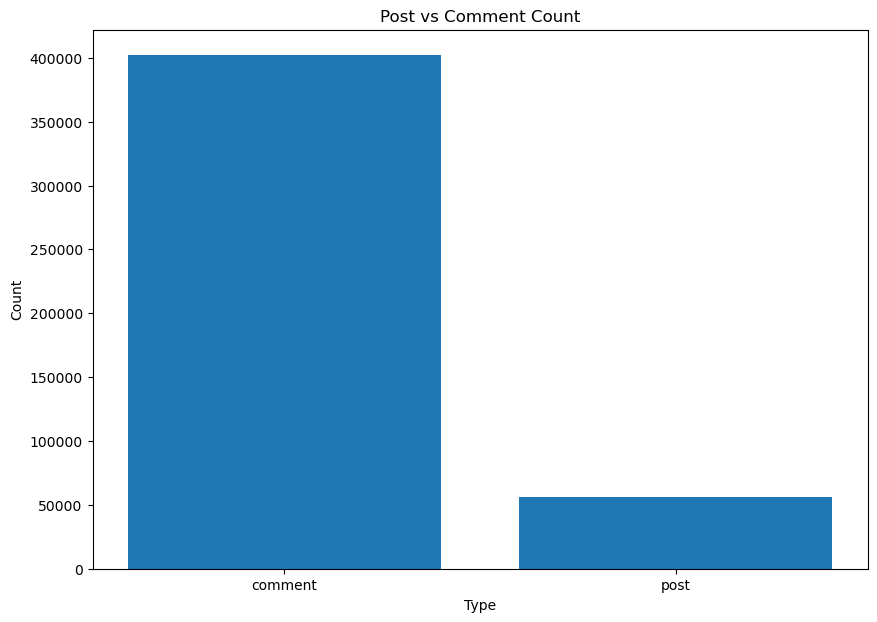

In [21]:
# Post vs. Comments
df['type'] = df['url'].apply(lambda x: 'post' if x != "No_URL" else 'comment')

type_counts = df['type'].value_counts()

plt.figure(figsize=(10, 7))
plt.bar(type_counts.index, type_counts.values)
plt.title('Post vs Comment Count')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# Most frequently used words in posts


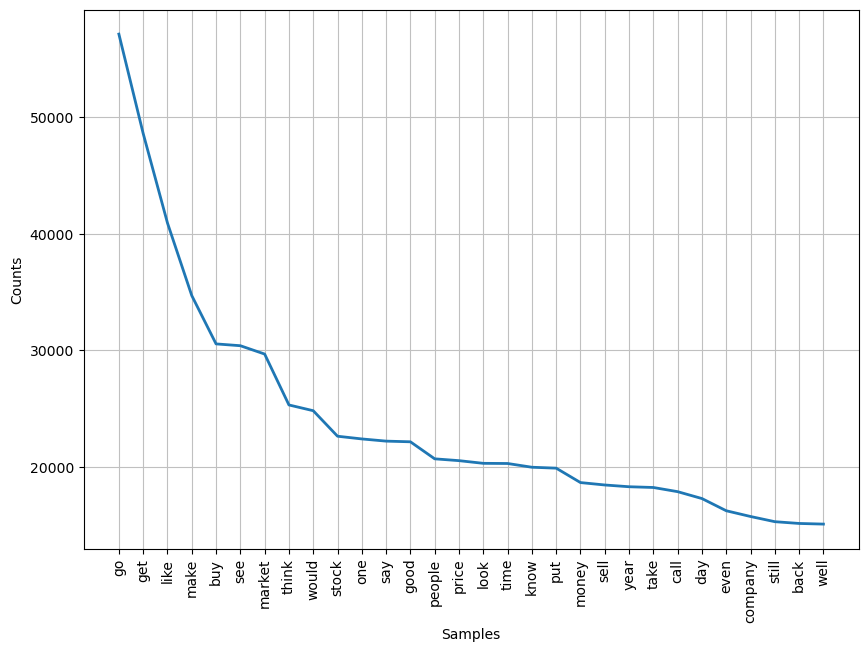

In [22]:
# Most frequently used words in posts
all_words = [word for tokens in df['tokens'] for word in tokens]
freq_dist = nltk.FreqDist(all_words)
plt.figure(figsize=(10, 7))
freq_dist.plot(30)
plt.show()

# Top 10 Most Common Words


In [23]:
# Top 10 Most Common Words
word_frequency = pd.Series(' '.join(df['processed_body']).split()).value_counts()[:10]
print(word_frequency)

go        57127
get       48600
like      40917
make      34686
buy       30539
see       30383
market    29667
think     25299
would     24805
stock     22615
dtype: int64


# Topic Distribution


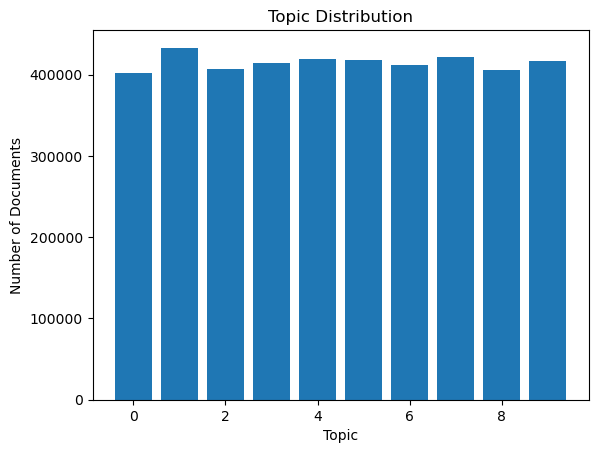

In [24]:
# Topic Distribution
topics = lda_model.get_document_topics(corpus)
topic_counts = np.zeros(10)
for doc_topics in topics:
    for topic in doc_topics:
        topic_counts[topic[0]] += 1

plt.bar(range(10), topic_counts)
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.show()

# Word Frequency in Topics


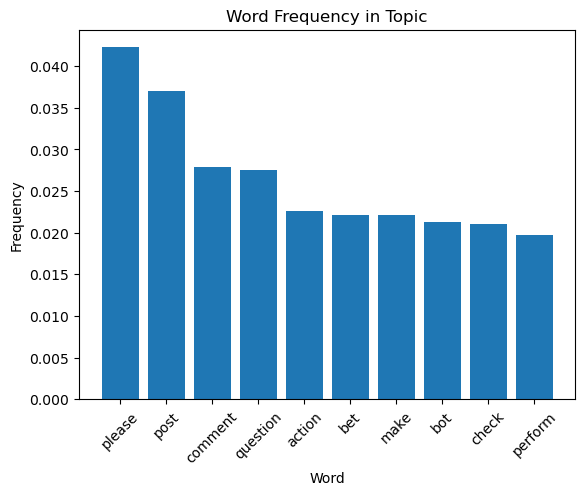

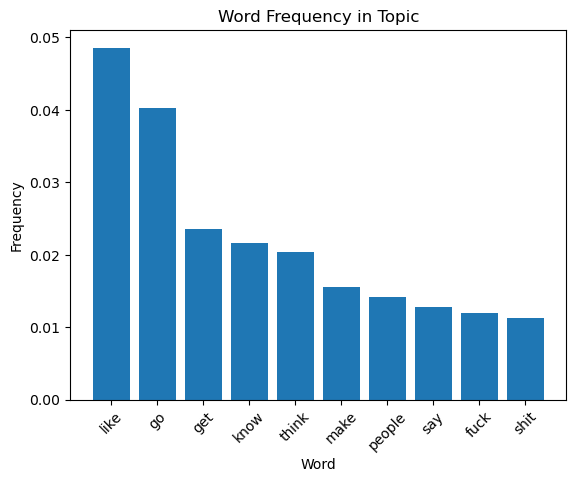

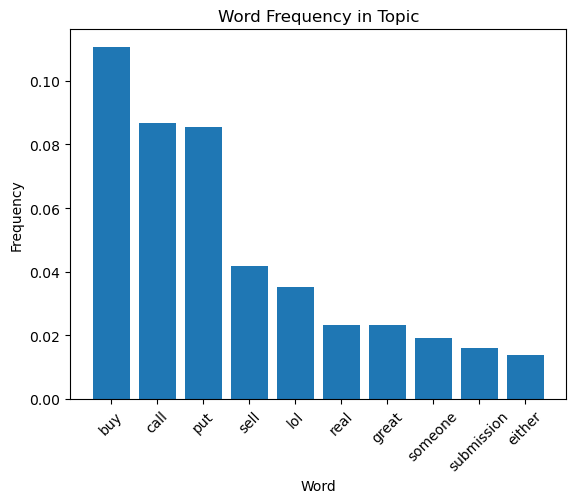

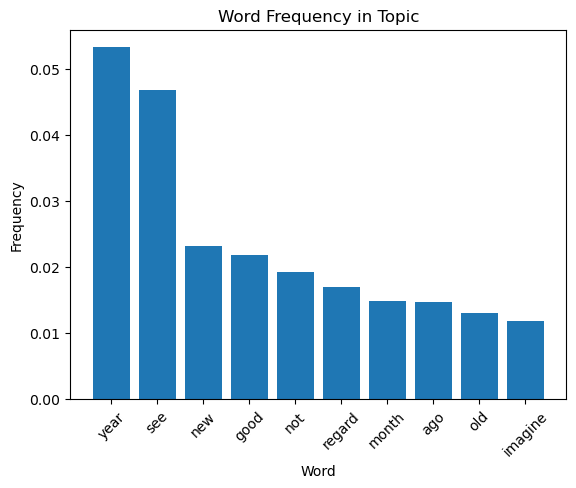

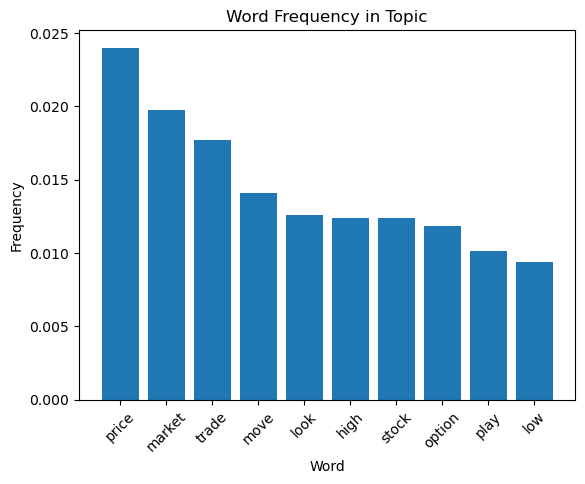

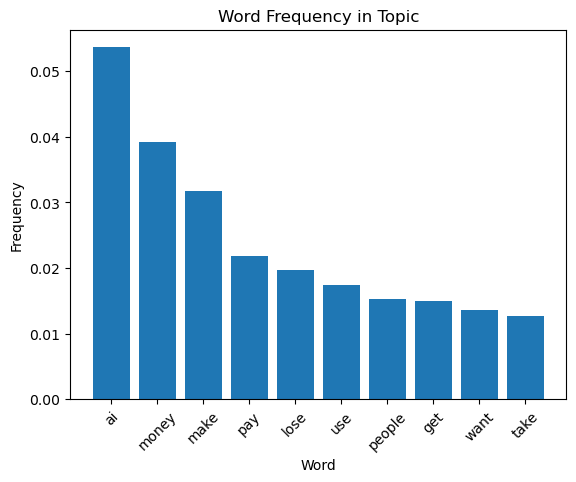

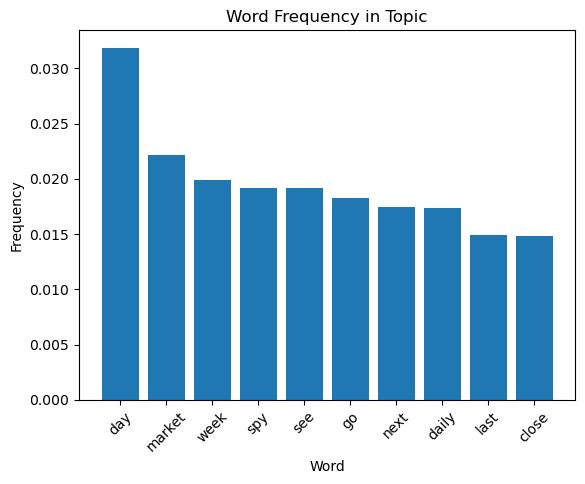

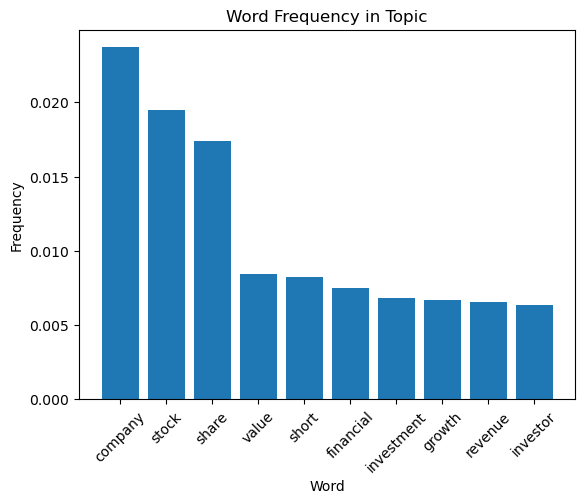

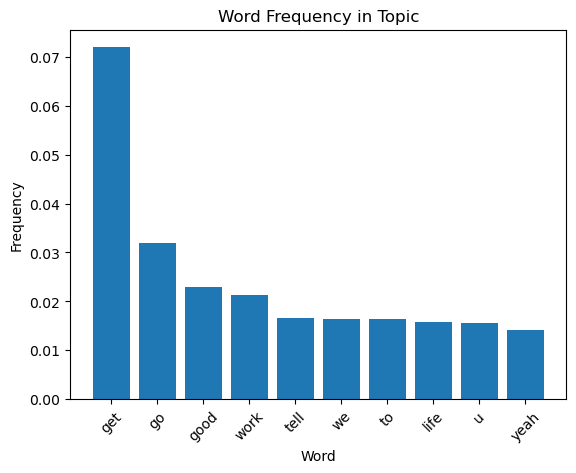

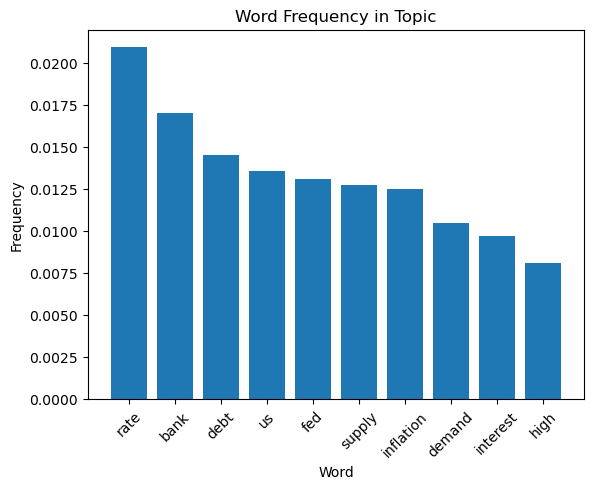

In [25]:
# Word Frequency in Topics
topics = lda_model.show_topics(num_topics=10, num_words=10, formatted=False)
for topic in topics:
    words = [word[0] for word in topic[1]]
    word_freq = [word[1] for word in topic[1]]
    plt.bar(words, word_freq)
    plt.title('Word Frequency in Topic')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()